In [3]:
# General import to be needed
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas

# import yfinance
import yfinance as yf


# Import warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Get SPY Data for last 1172 days
data = yf.download("SPY", start="2014-01-01", end="2021-03-06")
# Put into Pandas DataFrame
spy = pd.DataFrame(data)
spy.head()
#spy_data_pedro = spy.drop(columns=['Open', 'Close', 'Volume'])
#spy_data_pedro.rename(columns={"Adj Close": 'Close'}, inplace=True)
#spy_data_pedro.head()
#spy_data_pedro.to_csv("spy_data_pedro.csv")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,159.082428,119636900
2014-01-03,183.229996,183.600006,182.630005,182.889999,159.056351,81390600
2014-01-06,183.490005,183.559998,182.080002,182.360001,158.595398,108028200
2014-01-07,183.089996,183.789993,182.949997,183.479996,159.569473,86144200
2014-01-08,183.449997,183.830002,182.889999,183.520004,159.604202,96582300


In [5]:

# Clean Data and Drop non-essential columns
spy_data= spy.drop(columns=["High", "Low", "Open", "Volume", "Close"])
spy_data.columns = ["SPY Close"]
spy_data.head()

,SPY Close
Date,
2014-01-02,159.082428
2014-01-03,159.056351
2014-01-06,158.595398
2014-01-07,159.569473
2014-01-08,159.604202


In [6]:
# Calculate the portfolio daily returns
spy_data["Daily Returns"] = spy_data["SPY Close"].pct_change()


# Calculate the Cumulative returns
spy_data["Cumulative Returns"]= (1+ spy_data["Daily Returns"]).cumprod()-1

# Validate Data
spy_data.head()

,SPY Close,Daily Returns,Cumulative Returns
Date,,,
2014-01-02,159.082428,NaN,NaN
2014-01-03,159.056351,-0.000164,-0.000164
2014-01-06,158.595398,-0.002898,-0.003061
2014-01-07,159.569473,0.006142,0.003062
2014-01-08,159.604202,0.000218,0.003280


### Prepare Dataframe to Determine Benchmarks

In [7]:

# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
spy_evaluation_df = pd.DataFrame(index=metrics, columns=columns)


# Annualized Returns
spy_evaluation_df.loc['Annual Return'] = (
    spy_data['Daily Returns'].mean() * 252
)

# Calculate cumulative return
spy_evaluation_df.loc["Cumulative Returns"] =  (spy_data['Cumulative Returns'])

# Calculate annual volatility
spy_evaluation_df.loc['Annual Volatility'] = (
    spy_data['Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio 
spy_evaluation_df.loc['Sharpe Ratio'] = (
    spy_data['Daily Returns'].mean() * 252) / (
    spy_data['Daily Returns'].std() * np.sqrt(252)
)

# Calculate cumulative return
spy_evaluation_df.loc['Cumulative Returns'] = spy_data['Cumulative Returns'][-1]

# Calculate Downside Return
sortino_ratio_df = spy_data[['Daily Returns']]
sortino_ratio_df.loc[:,'Downside Returns'] = 0
sortino_ratio_df.head()

target = 0
mask = sortino_ratio_df['Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Daily Returns']**2

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

spy_evaluation_df.loc['Sortino Ratio'] = sortino_ratio

spy_evaluation_df

,Backtest
Annual Return,0.137828
Cumulative Returns,1.40364
Annual Volatility,0.174803
Sharpe Ratio,0.78848
Sortino Ratio,1.08839


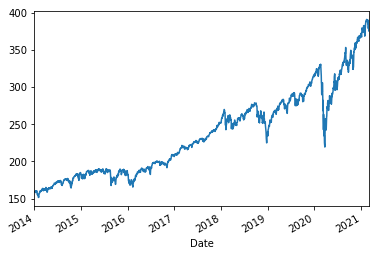

In [8]:
# Create Simple Plot of SPY Closing Prices
spy_data['SPY Close'].plot()

In [9]:
# HVPLOT SPY Close Data
spy_data.hvplot.line(x='Date', y='SPY Close', line_color="green")

:Curve   [Date]   (SPY Close)

In [10]:
#Get VIX Data for last 1172 days
vix = yf.download("^VIX", start="2014-01-01", end="2020-04-06")
vix.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,14.32,14.59,14.00,14.23,14.23,0
2014-01-03,14.06,14.22,13.57,13.76,13.76,0
2014-01-06,13.41,14.00,13.22,13.55,13.55,0
2014-01-07,12.38,13.28,12.16,12.92,12.92,0
2014-01-08,13.04,13.24,12.86,12.87,12.87,0


### Generate Additional Value For Neural Network

In [11]:
# Put VIX Into DataFrame
vix2 = pd.DataFrame(vix)
# Clean Data and Drop non-essential columns
vix_data= vix2.drop(columns=["High", "Low", "Open", "Volume", "Close"])
vix_data.columns = ["VIX Close"]
vix_data.head()
vix_data.describe()

,VIX Close
count,1575.000000
mean,15.676527
std,6.874577
min,9.140000
25%,12.345000
50%,14.020000
75%,16.714999
max,82.690002


In [12]:
# HVPLOT VIX Index Close Data
vix_data.hvplot.line(x='Date', y='VIX Close', line_color="blue")

:Curve   [Date]   (VIX Close)

In [13]:
# Combine SPY & VIX Dataframes
all_data = pd.concat([spy_data, vix_data],axis="columns", join="inner")
all_data.head()

,SPY Close,Daily Returns,Cumulative Returns,VIX Close
Date,,,,
2014-01-02,159.082428,NaN,NaN,14.23
2014-01-03,159.056351,-0.000164,-0.000164,13.76
2014-01-06,158.595398,-0.002898,-0.003061,13.55
2014-01-07,159.569473,0.006142,0.003062,12.92
2014-01-08,159.604202,0.000218,0.003280,12.87


In [14]:
spy_data.hvplot.line(x='Date', y='SPY Close',
                     line_color="green") * vix_data.hvplot.line(
                    x='Date', y='VIX Close', line_color="blue")

:Overlay
   .Curve.I  :Curve   [Date]   (SPY Close)
   .Curve.II :Curve   [Date]   (VIX Close)

In [15]:
all_data.hvplot(x='Date', y=['SPY Close', 'VIX Close'],
                value_label='Close Price', subplots=True, width=300, height=200)


:NdLayout   [Variable]
   :Curve   [Date]   (Close Price)

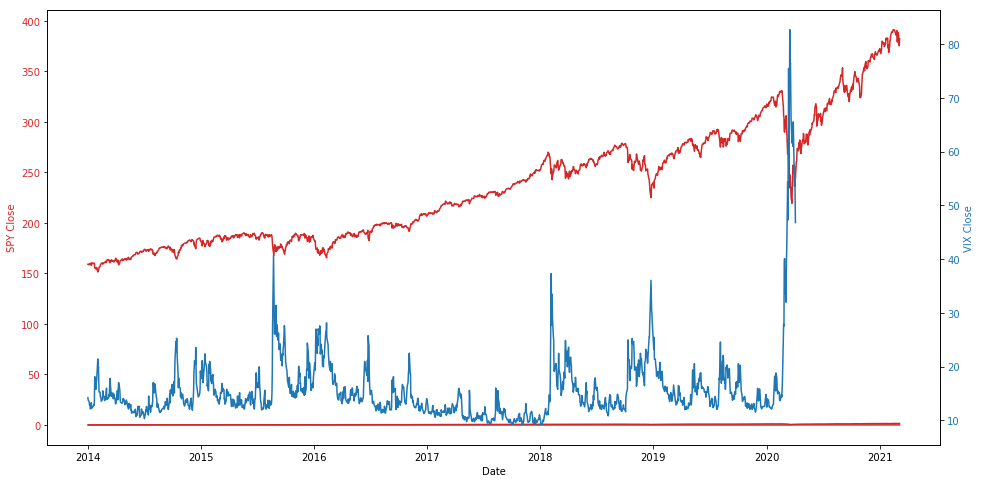

In [16]:
# Overlay Charts of SPY and VIX with a secondary y-axis
data1 = spy_data
data2 = vix_data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('VIX Close', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [17]:
# Evaluate Correlations between SPY & VIX (Inversely Correlated)
all_data.corr()

,SPY Close,Daily Returns,Cumulative Returns,VIX Close
SPY Close,1.000000,0.016011,1.000000,0.017238
Daily Returns,0.016011,1.000000,0.016011,-0.220018
Cumulative Returns,1.000000,0.016011,1.000000,0.017060
VIX Close,0.017238,-0.220018,0.017060,1.000000


### Add New Features Options Sentiment SPX

In [18]:
# Import Option Sentiment (1M 25 Delta Puts and Calls along with Spread and Ratios)
from pathlib import Path
filepath = ("ling.csv")
spyopt_df=pd.read_csv(filepath)
spyopt_df["Date"] = pd.to_datetime(spyopt_df["Date"], infer_datetime_format=True)
spyopt_df.set_index(("Date"), inplace=True)
spyopt_df.tail()

# We shift the options data delta -5 days to train model for prediction forecasting
#spyopt_df[['SPX 1M 25DP Vol BVOL INDEX','SPX 1M 25DC Vol BVOL INDEX','SPX 1M 100 Vol BVOL INDEX',
#          'P/C Ratio', 'P/C Spread', 'P/ATM Ratio', 'P/ATM Spread', 'ATM/C Ratio', 'ATM/C Spread']].shift(-5)

,SPX 1M 25DP Vol BVOL INDEX,SPX 1M 25DC Vol BVOL INDEX,SPX 1M 100 Vol BVOL INDEX,P/C Ratio,P/C Spread,P/ATM Ratio,P/ATM Spread,ATM/C Ratio,ATM/C Spread
Date,,,,,,,,,
2020-04-01,63.6275,41.4488,52.6290,1.54,22.18,1.21,11.00,1.27,11.18
2020-04-02,56.7444,36.8025,46.6374,1.54,19.94,1.22,10.11,1.27,9.83
2020-04-03,52.8947,35.8183,46.3582,1.48,17.08,1.14,6.54,1.29,10.54
2020-04-06,45.8773,31.1317,37.1560,1.47,14.75,1.23,8.72,1.19,6.02
2020-04-07,49.6727,32.6520,40.4303,1.52,17.02,1.23,9.24,1.24,7.78


In [19]:
# Concat all Dataframes Drop Null Values and Run Correlation
all_data2 = pd.concat([all_data, spyopt_df], axis=1)
all_data2.isnull().sum()
all_data2.dropna(inplace=True)
all_data2.head()

,SPY Close,Daily Returns,Cumulative Returns,VIX Close,SPX 1M 25DP Vol BVOL INDEX,SPX 1M 25DC Vol BVOL INDEX,SPX 1M 100 Vol BVOL INDEX,P/C Ratio,P/C Spread,P/ATM Ratio,P/ATM Spread,ATM/C Ratio,ATM/C Spread
Date,,,,,,,,,,,,,
2014-01-03,159.056351,-0.000164,-0.000164,13.76,11.9795,8.9814,10.1398,1.33,3.00,1.18,1.84,1.13,1.16
2014-01-06,158.595398,-0.002898,-0.003061,13.55,13.9644,10.3354,11.6945,1.35,3.63,1.19,2.27,1.13,1.36
2014-01-07,159.569473,0.006142,0.003062,12.92,12.7524,9.3597,10.6061,1.36,3.39,1.20,2.15,1.13,1.25
2014-01-08,159.604202,0.000218,0.003280,12.87,12.5946,9.1600,10.4178,1.37,3.43,1.21,2.18,1.14,1.26
2014-01-09,159.708572,0.000654,0.003936,12.89,12.5365,9.0315,10.2926,1.39,3.51,1.22,2.24,1.14,1.26


In [20]:
# Check to ensure NA's dropped and persisted
all_data2.isnull().sum()

SPY Close                     0
Daily Returns                 0
Cumulative Returns            0
VIX Close                     0
SPX 1M 25DP Vol BVOL INDEX    0
SPX 1M 25DC Vol BVOL INDEX    0
SPX 1M 100 Vol BVOL INDEX     0
P/C Ratio                     0
P/C Spread                    0
P/ATM Ratio                   0
P/ATM Spread                  0
ATM/C Ratio                   0
ATM/C Spread                  0
dtype: int64

In [21]:
# Key Values for Options Portion of the Data
'''
KEY
SPX 1M 25DP Vol BVOL INDEX = 1 Month 25 Delta Put Implied Volatility for SPX
SPX 1M 25DC Vol BVOL INDEX = 1 Month 25 Delta Call Implied Volatility for SPX
SPX 1M 100 Vol BVOL INDEX = 1 Month 100% Moneyness Implied Volatility for SPX
PC Ratio = Put/Call Ratio
P/C Spread = Put Call Spread 
P/ATM Ratio = Put ATM Ratio
P/ATM Spread = Put ATM Spread
ATM / C Ratio = Call ATM Ratio
ATM / C Spread = Call ATM Spread
'''
all_data2

,SPY Close,Daily Returns,Cumulative Returns,VIX Close,SPX 1M 25DP Vol BVOL INDEX,SPX 1M 25DC Vol BVOL INDEX,SPX 1M 100 Vol BVOL INDEX,P/C Ratio,P/C Spread,P/ATM Ratio,P/ATM Spread,ATM/C Ratio,ATM/C Spread
Date,,,,,,,,,,,,,
2014-01-03,159.056351,-0.000164,-0.000164,13.760000,11.9795,8.9814,10.1398,1.33,3.00,1.18,1.84,1.13,1.16
2014-01-06,158.595398,-0.002898,-0.003061,13.550000,13.9644,10.3354,11.6945,1.35,3.63,1.19,2.27,1.13,1.36
2014-01-07,159.569473,0.006142,0.003062,12.920000,12.7524,9.3597,10.6061,1.36,3.39,1.20,2.15,1.13,1.25
2014-01-08,159.604202,0.000218,0.003280,12.870000,12.5946,9.1600,10.4178,1.37,3.43,1.21,2.18,1.14,1.26
2014-01-09,159.708572,0.000654,0.003936,12.890000,12.5365,9.0315,10.2926,1.39,3.51,1.22,2.24,1.14,1.26
2014-01-10,160.143448,0.002723,0.006670,12.140000,12.6749,8.8244,10.1815,1.44,3.85,1.24,2.49,1.15,1.36
2014-01-13,158.012711,-0.013305,-0.006724,13.280000,12.5694,8.8717,10.1482,1.42,3.70,1.24,2.42,1.14,1.28
2014-01-14,159.734695,0.010898,0.004100,12.280000,12.5450,8.9831,10.1748,1.40,3.56,1.23,2.37,1.13,1.19
2014-01-15,160.595673,0.005390,0.009512,12.280000,13.6496,9.6140,11.1179,1.42,4.04,1.23,2.53,1.16,1.50


## Visualisation of All Data

In [22]:

all_data2.hvplot(x='Date', y=["SPX 1M 25DP Vol BVOL INDEX", "SPX 1M 25DC Vol BVOL INDEX",
                             "SPX 1M 100 Vol BVOL INDEX","P/C Ratio"], value_label='Implied Vol')

:NdOverlay   [Variable]
   :Curve   [Date]   (Implied Vol)

In [23]:
# Presenting Subplots for Presentation Purposes
all_data2.hvplot(x='Date', y=['SPX 1M 25DP Vol BVOL INDEX','SPX 1M 25DC Vol BVOL INDEX', 
                             'SPX 1M 100 Vol BVOL INDEX','SPY Close','VIX Close','P/C Ratio',
                             'P/C Spread','P/ATM Ratio','P/ATM Spread','ATM/C Ratio','ATM/C Spread'], 
                width=450, height=300, subplots=True, shared_axes=False, color="midnightblue").cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [24]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [25]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [26]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

### Set up a univariate function

In [27]:
def window_data(all_data2, window, feature_col_number, target_col_number):
#def window_data(df, window, all_data2.drop(columns=["SPY Close"]) , all_data2["SPY Close"]):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(all_data2) - window - 1):
        features = all_data2.iloc[i : (i + window), feature_col_number]
        target = all_data2.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)
# X feature everything but SPY Closing and - 10 days lookback to train

In [28]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 2

feature_column = 0
target_column = 0
X, y = window_data(all_data2, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[159.05635071 158.59539795]
 [158.59539795 159.56947327]
 [159.56947327 159.60420227]
 [159.60420227 159.70857239]
 [159.70857239 160.14344788]] 

y sample values:
[[159.56947327]
 [159.60420227]
 [159.70857239]
 [160.14344788]
 [158.01271057]]


In [29]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [30]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [31]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.04222991]
  [0.03966308]]

 [[0.03966308]
  [0.04508725]]

 [[0.04508725]
  [0.04528064]]

 [[0.04528064]
  [0.04586183]]

 [[0.04586183]
  [0.04828345]]] 

X_test sample values:
[[[0.59086684]
  [0.58965484]]

 [[0.58965484]
  [0.58607203]]

 [[0.58607203]
  [0.59681995]]

 [[0.59681995]
  [0.59281586]]

 [[0.59281586]
  [0.59676743]]]


In [32]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [33]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [34]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 5)              140       
_________________________________________________________________
dropout (Dropout)            (None, 2, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [35]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 1098 samples
Epoch 1/10
1098/1098 [==============================] - 18s 17ms/sample - loss: 0.0016
Epoch 2/10
1098/1098 [==============================] - 9s 8ms/sample - loss: 0.0056
Epoch 3/10
1098/1098 [==============================] - 10s 9ms/sample - loss: 0.0058
Epoch 4/10
1098/1098 [==============================] - 9s 9ms/sample - loss: 0.0051
Epoch 5/10
1098/1098 [==============================] - 9s 9ms/sample - loss: 0.0036
Epoch 6/10
1098/1098 [==============================] - 10s 9ms/sample - loss: 0.0029
Epoch 7/10
1098/1098 [==============================] - 9s 9ms/sample - loss: 0.0024
Epoch 8/10
1098/1098 [==============================] - 10s 9ms/sample - loss: 0.0025
Epoch 9/10
1098/1098 [==============================] - 9s 9ms/sample - loss: 0.0025
Epoch 10/10
1098/1098 [==============================] - 9s 9ms/sample - loss: 0.0021


In [36]:
# Evaluate the model
model.evaluate(X_test, y_test)

472/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.03220197451064142

In [37]:
# Make some predictions
predicted = model.predict(X_test)

In [38]:
# origanal price instead of the scaled version 
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [39]:
# Create a DataFrame of Real and Predicted values for the 1 day lookback
spy_model_px = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
spy_model_px.head()
#spy_model_px.to_csv("RealPred.csv")

,Real,Predicted
0,256.719727,251.670959
1,258.649841,251.650925
2,257.930786,251.600388
3,258.640411,251.761307
4,258.110626,251.703232


In [40]:
all_data2.to_csv("TheData.csv")

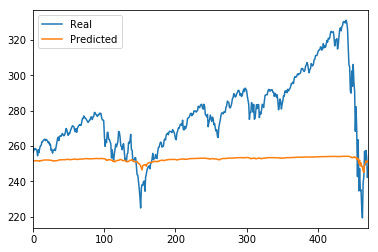

In [41]:
spy_model_px.plot()

## Bring in FICC Data

In [42]:

# Bring in Bond Data BAML OAS Fixed Income Spread
FICC_df = pd.read_csv("BAMLOASFICC.csv")
FICC_df["DATE"] = pd.to_datetime(FICC_df["DATE"], infer_datetime_format=True)
FICC_df.rename(columns = {'DATE':'Date'}, inplace = True) 
FICC_df.rename(columns = {'BAMLH0A0HYM2':'FICC_Spread'}, inplace = True)
FICC_df['FICC_Spread']=FICC_df['FICC_Spread'].astype('str')
FICC_df.set_index(("Date"), inplace=True)
FICC_df['FICC_Spread'] = pd.to_numeric(FICC_df['FICC_Spread'], errors='coerce')
FICC_df.dropna(inplace=True)
FICC_df.dtypes

FICC_Spread    float64
dtype: object

In [43]:
# Bring in TED Spread Data
Ted_df = pd.read_csv("TEDRATE.csv")
Ted_df["Date"] = pd.to_datetime(Ted_df["Date"],infer_datetime_format=True) 

Ted_df['TEDSPREAD']=Ted_df['TEDSPREAD'].astype('str')
Ted_df.set_index(("Date"), inplace=True)
Ted_df['TEDSPREAD'] = pd.to_numeric(Ted_df['TEDSPREAD'], errors='coerce')
Ted_df.dropna(inplace=True)
Ted_df.head()
Ted_df.isnull().sum()

TEDSPREAD    0
dtype: int64

In [44]:
# Bring in Gold Prices
gold_df = pd.read_csv("Gold.csv")
gold_df["Date"] = pd.to_datetime(gold_df["Date"], infer_datetime_format=True)
gold_df.set_index(("Date"), inplace=True)
# Rename Gold Price Close
gold_df.rename(columns={'GOLDAMGBD228NLBM':'Gold_Close'}, inplace=True)
gold_df['Gold_Close'] = gold_df['Gold_Close'].astype('str')
gold_df['Gold_Close'] = pd.to_numeric(gold_df['Gold_Close'], errors='coerce')
gold_df.dropna(inplace=True)
gold_df.isnull().sum()

Gold_Close    0
dtype: int64

In [45]:
# Bring in 10Y - 2Y Treasury
treasury_df = pd.read_csv("T10Y2Y.csv")
treasury_df['Date'] = pd.to_datetime(treasury_df['Date'], infer_datetime_format=True)
treasury_df.set_index(('Date'), inplace=True)
# Rename Column delta_10Y2Y
treasury_df.rename(columns={'T10Y2Y': 'Delta_10Y2Y'}, inplace=True)
treasury_df['Delta_10Y2Y'] = treasury_df['Delta_10Y2Y'].astype('str')
treasury_df['Delta_10Y2Y'] = pd.to_numeric(treasury_df['Delta_10Y2Y'], errors = 'coerce')
treasury_df.dropna(inplace=True)
treasury_df.head()
treasury_df.isnull().sum()

Delta_10Y2Y    0
dtype: int64

In [46]:
# Bring in 10 Year Treasury Yield
yield_10_df = pd.read_csv('10Y.csv')
yield_10_df['Date'] = pd.to_datetime(yield_10_df['Date'], infer_datetime_format=True)
yield_10_df.set_index(('Date'), inplace=True)
# Convert Dtypes
yield_10_df['10Y_Yield'] = yield_10_df['10Y_Yield'].astype('str')
yield_10_df['10Y_Yield'] = pd.to_numeric(yield_10_df['10Y_Yield'], errors = 'coerce')
yield_10_df.dropna(inplace=True)
yield_10_df.head()
yield_10_df.isnull().sum()

10Y_Yield    0
dtype: int64

In [47]:
# Bring in 10Y - 3M Treasury
treasury_3df = pd.read_csv("T10Y3M.csv")
treasury_3df['Date'] = pd.to_datetime(treasury_3df['Date'], infer_datetime_format=True)
treasury_3df.set_index(('Date'), inplace=True)
# Rename Column delta_10Y3M
treasury_3df.rename(columns={'T10Y3M': 'Delta_10Y3M'}, inplace=True)
treasury_3df['Delta_10Y3M'] = treasury_3df['Delta_10Y3M'].astype('str')
treasury_3df['Delta_10Y3M'] = pd.to_numeric(treasury_3df['Delta_10Y3M'], errors = 'coerce')
treasury_3df.dropna(inplace=True)
treasury_3df.head()
treasury_df.isnull().sum()

Delta_10Y2Y    0
dtype: int64

## Combine New Data Set (FICC, Gold, TED, Treasury)

In [48]:
# Concat all Dataframes Drop Null Values and Run Correlation
all_data3 = pd.concat([all_data2, FICC_df, Ted_df, gold_df, treasury_df, 
                       yield_10_df, treasury_3df], axis=1)
all_data3.isnull().sum()
all_data3.dropna(inplace=True)
all_data3.head()
all_data3.corr()
for col in all_data3.columns: 
    print(col)

SPY Close
Daily Returns
Cumulative Returns
VIX Close
SPX 1M 25DP Vol BVOL INDEX
SPX 1M 25DC Vol BVOL INDEX
SPX 1M 100 Vol BVOL INDEX
P/C Ratio
P/C Spread
P/ATM Ratio
P/ATM Spread
ATM/C Ratio
ATM/C Spread
FICC_Spread
TEDSPREAD
Gold_Close
Delta_10Y2Y
10Y_Yield
Delta_10Y3M


## Bring In Sentiment Data

In [49]:
# Bring in Sentiment Data (export_sent_all)
sentiment_df = pd.read_csv("export_sent_all.csv")
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], infer_datetime_format=True)
# Take out seconds 
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.floor('d')
sentiment_df.set_index(('Date'), inplace=True)


# Run this code and comment out below code if you want NA's = 0
sentiment_df.fillna((0), inplace=True)
sentiment_df.count()

# Run this code and comment out above code if you want NA's = Random
#import random
#sentiment_df.fillna(random.random(), inplace=True)
#sentiment_df.isnull().sum()

sentiment_df

,SP500 Compound,SP500 Negative,SP500 Neutral,SP500 Positive,SP500 Text,Cramer Compound,Cramer Negative,Cramer Neutral,Cramer Positive,Cramer Text,...,FED Compound,FED Negative,FED Neutral,FED Positive,FED Text,Fink Compound,Fink Negative,Fink Neutral,Fink Positive,Fink Text
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-14,-0.1779,0.045,0.955,0.000,"the parnassus endeavor fund (trades, portfolio...",0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,0.3182,0.000,0.953,0.047,"looking at the chart below, it’s fair to say t...",0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,0.1027,0.049,0.892,0.059,"stock futures, premarket data and performance ...",0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,0.6908,0.000,0.872,0.128,tuesday morning brought some relief for invest...,0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,0.0000,0.000,1.000,0.000,its been a rough couple of months for all inve...,0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,-0.4854,0.146,0.784,0.070,watching the bull market turn into a bear mark...,0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,0.0533,0.098,0.766,0.136,it has been a long time since the u.s. economy...,0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,0.0000,0.000,1.000,0.000,"boeing co.\r\n ba, \r\n -1.40%\r\nsaid tuesday...",0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0
2020-04-14,0.0000,0.000,1.000,0.000,stocks rose tuesday as investors considered si...,0.0,0.0,0.0,0.0,0,...,0.0000,0.000,0.000,0.000,0,0.0000,0.000,0.000,0.000,0


In [50]:
# Export altered sentiment df's first one with 0 values and second one with random NA values
sentiment_df.to_csv("sentiment_clean.csv")
sentiment_df.to_csv("sentiment_random.csv")

In [ ]:
#Sentiment Analysis issues mergeing b/c duplciate dates on sentiment analysis
# Concat Data 3 with new Sentiment Dataframes
# Concat all Dataframes Drop Null Values and Run Correlation
all_data4 = pd.concat([all_data3, sentiment_df], axis='columns', join='inner')
all_data2.isnull().sum()

all_data4.head()
all_data2.describe()
all_data2.corr()

In [ ]:
# Adding Subplots for Presentation Purposes
all_data3.hvplot(x='Date', y=['SPY Close', 'VIX Close','SPX 1M 25DP Vol BVOL INDEX','SPX 1M 25DC Vol BVOL INDEX', 
                              'SPX 1M 100 Vol BVOL INDEX','P/C Ratio', 'P/C Spread','P/ATM Ratio','P/ATM Spread',
                              'ATM/C Ratio','ATM/C Spread','FICC_Spread', 'TEDSPREAD', 'Gold_Close',
                             'Delta_10Y2Y', 'Delta_10Y3M','10Y_Yield'], 
                width=450, height=300, subplots=True, shared_axes=False, color="midnightblue").cols(2)

In [ ]:
all_data3.to_csv("TheData.csv")

# Plots

In [ ]:
# Overlay Charts of SPY and TED SPREADs with a secondary y-axis
data1 = spy_data
data2 = Ted_df

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('TED Spread', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:
# Overlay Charts of SPY and VIX with a secondary y-axis
data1 = spy_data
data3 = vix_data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('VIX Close', color=color)  # we already handled the x-label with ax1
ax2.plot(data3, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:
# Overlay Charts of SPY and Gold with a secondary y-axis
data1 = spy_data
data4 = gold_df

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Gold Close', color=color)  # we already handled the x-label with ax1
ax2.plot(data4, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:

# Overlay Charts of SPY and FICC HY Spread with a secondary y-axis
data1 = spy_data
data5 = FICC_df

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Bond Spreads', color=color)  # we already handled the x-label with ax1
ax2.plot(data5, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:
# Overlay Charts of SPY and Treasury with a secondary y-axis
data1 = spy_data
data6 = yield_10_df

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('10Y Yield', color=color)  # we already handled the x-label with ax1
ax2.plot(data6, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:
# Overlay Charts of SPY and Treasury 10/2 Spread with a secondary y-axis
data1 = spy_data
data7 = treasury_df

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Treasury 10/2 Spread', color=color)  # we already handled the x-label with ax1
ax2.plot(data7, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:
# Overlay Charts of SPY and Treasury 10/3M Spread with a secondary y-axis
data1 = spy_data
data8 = treasury_df

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Treasury 10/3M Spread', color=color)  # we already handled the x-label with ax1
ax2.plot(data8, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:
# Overlay Charts of SPY and Treasury 10/2 Spread with a secondary y-axis
data1 = spy_data
data7 = treasury_df
data8 = treasury_3df

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('SPY Close', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Treasury 10/2 Spread', color=color)  # we already handled the x-label with ax1
ax2.plot(data7, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()

color = 'tab:purple'
ax3.set_ylabel('Treasury 10/3M Spread', color=color)  # we already handled the x-label with ax1
ax3.plot(data8, color=color)
ax3.tick_params(axis='y', labelcolor=color)


plt.gcf().set_size_inches(16, 8)
plt.show()

In [ ]:
all_data3.to_csv("TheData.csv")

In [ ]:
sentiment_df = pd.read_csv("export_sent3_df.csv")
sentiment_df.head()